In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
%matplotlib inline
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action='ignore')

# Lecture 19 #

## The Bootstrap ##

In [2]:
# Read in the table & filter for people who worked half-time or more
sf = Table.read_table('san_francisco_2019.csv')

min_salary = 15 * 20 * 50
sf = sf.where('Salary', are.above(min_salary))

In [3]:
# Look at how many people are in our dataset
sf.num_rows

37103

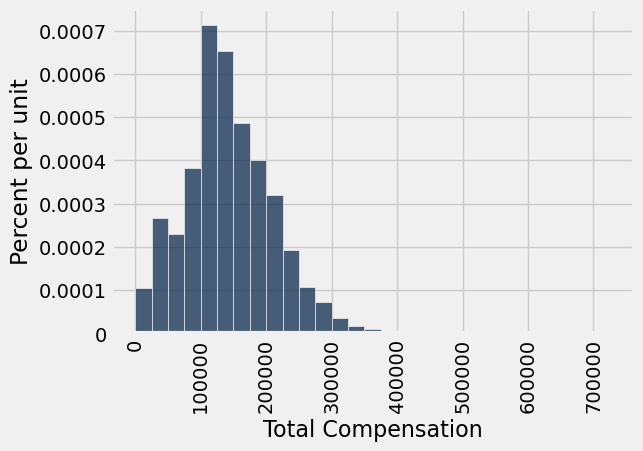

In [4]:
# Visualize the population's total compensation
sf_bins = np.arange(0, 726000, 25000)
sf.hist('Total Compensation', bins=sf_bins)

In [5]:
# A function that finds the median total compensation of a given table
def median_comp(t):
    return percentile(50, t.column('Total Compensation'))

median_comp(sf)

135747.0

In [6]:
# One random sample
sample_size = 100

our_sample = sf.sample(sample_size, with_replacement=False)
median_comp(our_sample)

138308.0

In [7]:
# Create a 95% confidence interval
num_repetitions = 1000
bstrap_medians = make_array()

for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, median_comp(our_sample.sample()))

left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right)

array([124650., 160744.])

## Confidence Intervals ##

In [8]:
# Create a function that samples from the sf table & returns a 95% confidence interval
def confidence_interval_95(sample_size):
    our_sample = sf.sample(sample_size, with_replacement=False)
    
    num_repetitions = 1000
    bstrap_medians = make_array()

    for i in np.arange(num_repetitions):
        bstrap_medians = np.append(bstrap_medians, median_comp(our_sample.sample()))

    left = percentile(2.5, bstrap_medians)
    right = percentile(97.5, bstrap_medians)

    return make_array(left, right)

confidence_interval_95(400)

array([130789., 148278.])

In [9]:
intervals = Table(['k', 'left', 'right'])

for k in np.arange(100):
    interval = confidence_interval_95(400)
    intervals = intervals.with_row([k, interval.item(0), interval.item(1)])
    
intervals.show(4)

k,left,right
0,132682,144562
1,127825,142867
2,127606,140012
3,126285,138544


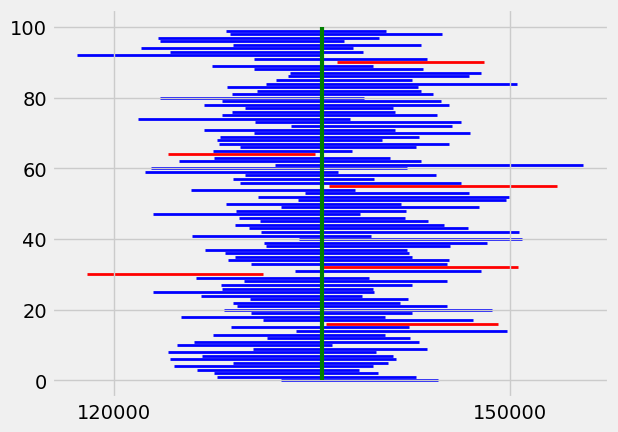

In [10]:
truth = median_comp(sf)

plots.plot((truth, truth), (0, intervals.num_rows), color='green', lw=3)
plots.xticks([120000, 150000])

for row in intervals.rows:
    if row.item('left') > truth or row.item('right') < truth:
        color = 'red'
    else:
        color = 'blue'
    plots.plot((row.item('left'), row.item('right')),
               (row.item('k'), row.item('k')),
               color, lw=2, zorder=-1)

## Confidence Interval for Unknown Population Mean

In [11]:
# One random sample of mother-newborn pairs
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


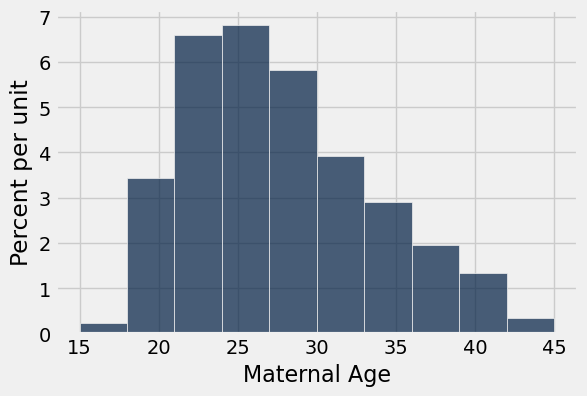

In [12]:
# Visualize the sample's maternal age
births.hist('Maternal Age')

In [13]:
# Average age of mothers in the sample
np.average(births.column('Maternal Age'))

27.228279386712096

### Question ###
What is the average age of the mothers in the population?

In [14]:
# Create a function that bootstraps a sample & returns the mean
def one_bootstrap_mean():
    resample = births.sample()
    return np.average(resample.column('Maternal Age'))

In [15]:
# Generate 3000 bootstrap sample means
num_repetitions = 3000
bstrap_means = make_array()

for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

### Bootstrap Percentile Method for Confidence Interval

The interval of estimates is the "middle 95%" of the bootstrap estimates.

This is called a *95% confidence interval* for the mean age in the population.

In [16]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([26.9011925 , 27.56558773])

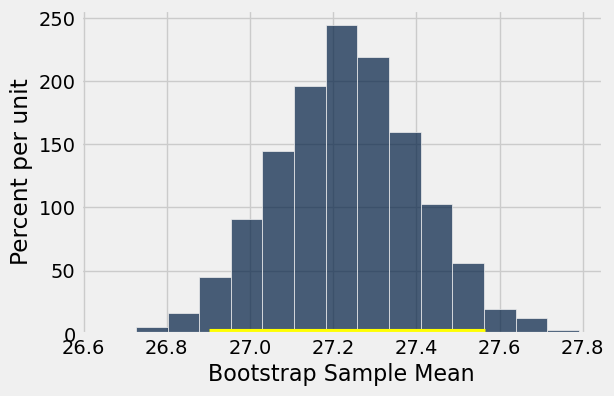

In [17]:
# Visualize an empirical distribution of the statistic
resampled_means = Table().with_columns('Bootstrap Sample Mean', bstrap_means)

resampled_means.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);

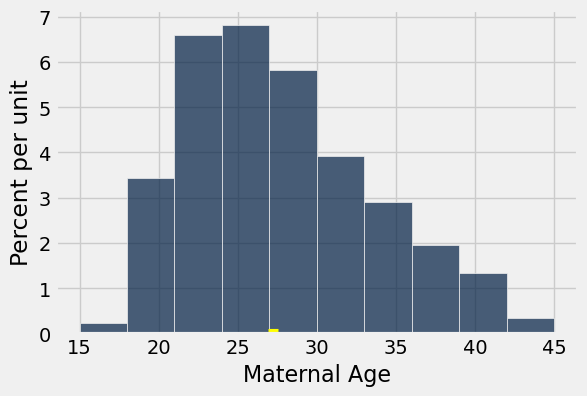

In [18]:
# Visualize our 95% confidence interval & the empirical distribution of the sample
births.hist('Maternal Age')
plots.plot([left, right], [0, 0], color='yellow', lw=8);

## Using the Confidence Interval for Testing Hypotheses

**Null:** The average age of mothers in the population is 25 years; the random sample average is different due to chance.

**Alternative:** The average age of the mothers in the population is not 25 years.

Suppose you use the 5% cutoff for the p-value.

Based on the confidence interval, which hypothesis would you pick?